# ARTIFIVE-POTSDAM DEMO

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
# TODO:
# o check training transforms
# o get rid of "preremove_empty"

In [3]:
from pathlib import Path

import torch as th
import torchvision as tv
import pytorch_lightning as pl

from commonimagedataset import CommonImageDataset, collate_fn
from open_turbo_jpeg import open_turbo_jpeg
from transformations import *

import matplotlib.pyplot as plt

from visualization import draw_rectangles

In [4]:
data_path = Path("/fastdata/ISPRS_BENCHMARK_DATASETS/Potsdam/processed/annotated_images/v4_unpadded//patches_600x600/training/")
target_filename = "annotations*.json"

/home/mtadmin/miniconda3/envs/dev_pytorch18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
min_size = 20
max_size = 200
min_either_size = 40

def sample_preprocessor(sample):
    # this removes polygons whose bounds are outside of the specified limits
    # it is applied as a preprocessing step
    polys = sample["annotations"]["polygons"] 
    if len(polys):
        polys_tensored = th.tensor([p.bounds for p in polys])
        sizes = polys_tensored[:,2:] - polys_tensored[:, :2]
        keeper = ((sizes > min_size) & (sizes < max_size)).all(-1)
        keeper = keeper & (sizes > min_either_size).any(-1)
        for k, vs in sample["annotations"].items():
            sample["annotations"][k] = [v for v, keep in zip(vs, keeper) if keep]
    return sample

def drop_targets(input, target):
    # just removes empty polygons
    if "polygons" in target:
        drop_list = [p.is_empty for p in target["polygons"]]
        for key, values in target.items():
            target[key] = [v for v, drop in zip(values, drop_list) if not drop]
    return input, target

In [6]:
data_stats_imagenet = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
data_mean = data_stats_imagenet[0]
data_std = data_stats_imagenet[1]

transforms = Compose([
    Pad(th.Size([600, 600])),
    Resize((300, 300)),
    StandardNormalize(data_mean, data_std),
    clip_polys, # clip to image bounds
    drop_targets, # remove empty polygons
    polys_to_boxes, # convert polygons to bounding boxes and add them
    drop_polys, # remove polygons
    geometry_to_bounds, # convert shapely bounding boxes to tensors
])

preremove_empty = True # this removes empty samples in preprocessing
dataset = CommonImageDataset(
    data_path, target_filename, 
    transformation=transforms, 
    preremove_empty=preremove_empty, sample_preprocessor=sample_preprocessor,
    image_loading_fn=open_turbo_jpeg,
    add_segmentation=True,
)

batch_size = 32
num_workers = 8
dataloader = th.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=collate_fn)

## show a single batch

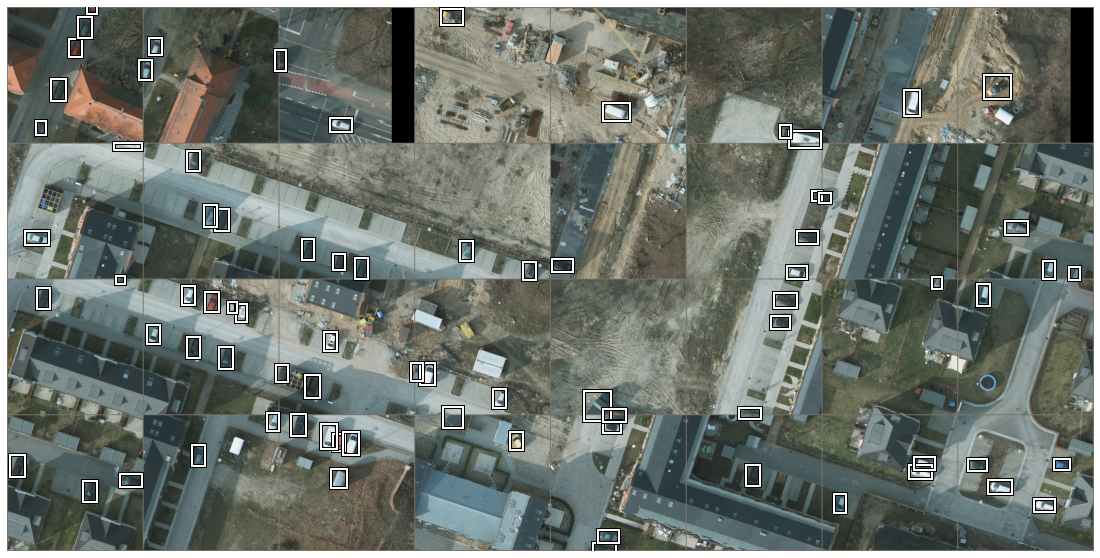

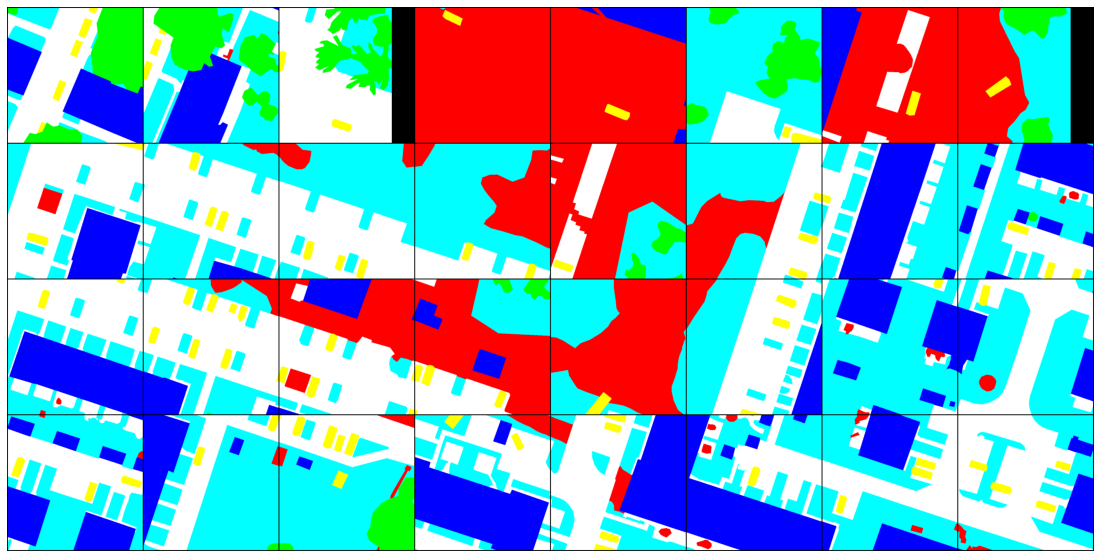

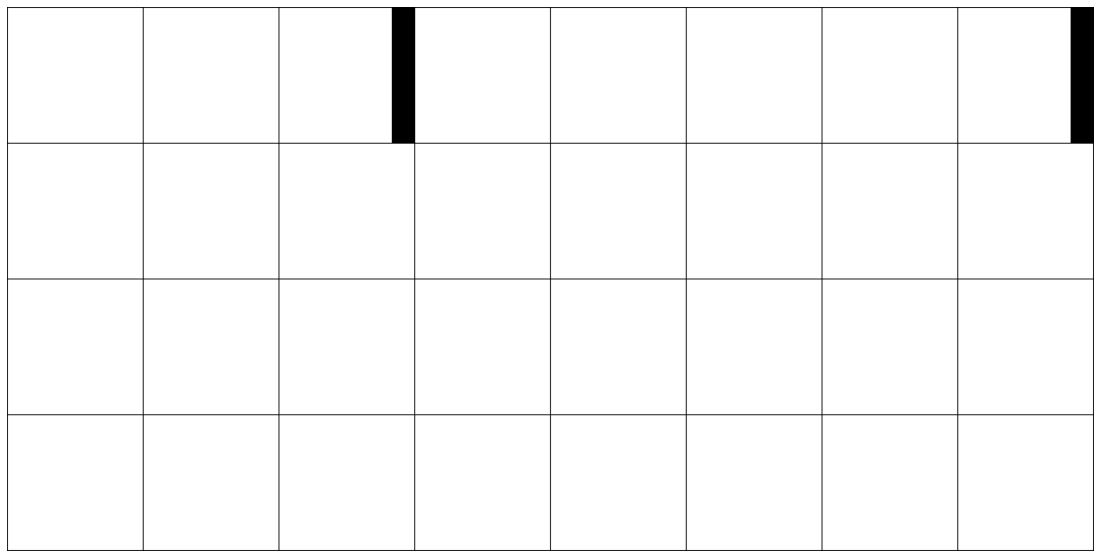

In [7]:
batch = next(iter(dataloader))

n_cols = 8
padding = 2
f, ax = plt.subplots(figsize=(20, 10))
ax.imshow(tv.utils.make_grid(batch[0]["image"], n_cols, padding).permute(1, 2, 0).mul(th.as_tensor(data_std)).add(th.as_tensor(data_mean)))
ax.axis(False);

_, h, w = batch[0]["image"][0].shape
j = -1
for i, bxs in enumerate(batch[1]["boxes"]):
    bxs = bxs.clone()
    bxs[:,::2] = bxs[:,::2] + (w + padding) * (i % n_cols)
    if i % n_cols == 0:
        j += 1
    bxs[:,1::2] = bxs[:,1::2] + (h + padding) * j
    draw_rectangles(ax, bxs)

f, ax = plt.subplots(figsize=(20, 10))
ax.imshow(tv.utils.make_grid(batch[0]["segmentation"], n_cols, padding).permute(1, 2, 0))
ax.axis(False);

f, ax = plt.subplots(figsize=(20, 10))
ax.imshow(tv.utils.make_grid(batch[0]["mask"], n_cols, padding).permute(1, 2, 0))
ax.axis(False);